<a href="https://colab.research.google.com/github/lgvaz/faststyle/blob/master/examples/style_incremental_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !nvidia-smi

In [0]:
import gc
try:
  from fastai2.basics import *
  from fastai2.vision.all import *
  from faststyle import *
except ImportError:
  !pip install -q git+git://github.com/fastai/fastcore.git
  !pip install -q git+git://github.com/fastai/fastai2.git
  !pip install -q git+https://github.com/lgvaz/faststyle.git

In [4]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  root_dir = Path('/content/gdrive/My Drive/')
except ImportError:
  root_dir = Path('.')

Mounted at /content/gdrive


In [0]:
source = untar_data(URLs.COCO_SAMPLE)

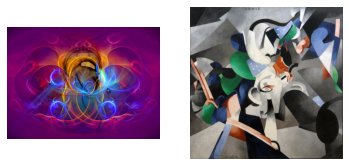

In [6]:
# Fix styles for colab
style_dir = Path('styles')
style_fns = L('abstract_digital1.jpg', 'udnie.jpg')
style_fns = style_fns.map(lambda o: style_dir/o)
show_images([PILImage.create(fn) for fn in style_fns])

In [0]:
splitter = RandomSplitter(.1, seed=random.randint(0,1e6))
def get_dls(sz,bs):
  dblock = DataBlock(style_blocks, get_items=get_image_files, splitter=splitter,
                     item_tfms=[Resize(sz)],
                     batch_tfms=[*aug_transforms(), NormalizeX.from_stats(*coco_stats)])
  return dblock.dataloaders(source, bs=bs)

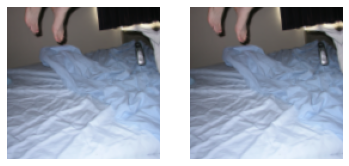

In [8]:
get_dls(128,bs=1).show_batch()

In [0]:
get_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [0]:
# TODO: Should go together with drive import or something
save_dir = root_dir/'dl/faststyle'

In [0]:
loss_func = FastStyleLoss(stl_w=3e5, tv_w=300)

@delegates(get_dls)
def get_learner(m, **kwargs):
  learn = None; gc.collect()
  learn = style_learner(get_dls(**kwargs),m,get_feats,style_fns,loss_func=loss_func)
  learn.path = save_dir
  return learn

In [0]:
def predict_test(learn):
  preds_dir = save_dir/'preds'; preds_dir.mkdir(exist_ok=True)
  imgs_dir = Path('imgs')
  fns = ['lindsey.png']
  fns = L(fns).map(lambda o: imgs_dir/o)
  dset = Datasets(fns, tfms=[[PILImageX.create], [PILImage.create]])
  after_item = [RatioResize(1024), ToTensor()]
  dl = learn.dls.valid.new(dset, after_item=after_item)
  _,_,preds = learn.get_preds(dl=dl, with_decoded=True)
  imgs = L(PILImage.create(TensorImage((pred*255).long())) for pred in preds)
  for img,fn in zip(imgs,fns): img.save(preds_dir/fn.name)

In [0]:
m = TransformerNet()

In [0]:
szs  = [256,512,1024]
bss  = [26, 8, 2]
lrs  = [1e-3,1e-3,5e-4]
pcts = [1.,.6,.4]

In [0]:
name = '-'.join(style_fns.map(lambda o: o.stem))

In [0]:
for i,(sz,bs,lr,pct) in enumerate(zip(szs,bss,lrs,pcts)):
  learn = get_learner(m, sz=sz, bs=bs)
  try: learn.load(name+f'_{szs[min(0,i-1)]}');    print('Loaded model')
  except FileNotFoundError:                       print('Failed to load model')
  learn.fit(1, lr, cbs=[ShortEpochCallback(pct=pct)])
  learn.save(name+f'_{sz}')
  predict_test(learn)

Failed to load model


epoch,train_loss,valid_loss,stl,cnt,tv,time
0,13.529193,15.678610,5.028226,9.769379,0.881003,11:50


Loaded model


epoch,train_loss,valid_loss,stl,cnt,tv,time


In [0]:
export_dir = save_dir/'exports'; export_dir.mkdir(exist_ok=True)
learn.export(export_dir/f'{name}.pkl')